In [1]:
"""
Exploratory data analysis for the weather-airports project.

Part 1a: Weather events

Weather data: https://www.kaggle.com/sobhanmoosavi/us-weather-events
Flight delays/cancellations: https://www.transtats.bts.gov/DL_SelectFields.asp
Busiest airports: https://www.faa.gov/airports/planning_capacity/passenger_allcargo_stats/passenger/media/preliminary-cy18-commercial-service-enplanements.pdf
"""

from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pytz
import warnings
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

START_YEAR = 2016
END_YEAR = 2019
save_data = True#; save_data = False #whether to save the resulting data

In [2]:
'''Data collection'''
stopwatch = TimeTracker.TimeTracker()
# Get all the data.
path = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data'
os.chdir(path)
print('Importing weather events CSV file')
weather_events = pd.read_csv('US_WeatherEvents_2016-2019.csv')

Importing weather events CSV file


In [3]:
# Check for any duplicates.
nRows = len(weather_events.index)
weather_events.drop_duplicates(inplace=True)
print('Any duplicates dropped?', len(weather_events.index)!=nRows) #No duplicates.

Any duplicates dropped? False


A source for the 2019 data was not available at this time, so I assume that the 2018
busiest airport rankings are the same. Either way there should not have been a major
dropoff in passenger numbers at the US's busiest airports between 2018 and 2019.

In [4]:
# Get the busiest airports in the US.
busiest_US_airports2018 = ['ATL','LAX','ORD','DFW','DEN','JFK','SFO','SEA',
                           'LAS','MCO','EWR','CLT','PHX','MIA','IAH','BOS']
busiest_US_airports2018 = pd.Series(
    busiest_US_airports2018, index=range(1, len(busiest_US_airports2018)+1),
    name='Airport')
busiest_US_airports2018.index.name = 'Rank'
if save_data:
    busiest_US_airports2018.to_csv('busiest_US_airports2018.csv') #For Part 1b

In [5]:
'''Explore the weather data.'''
# Take a couple airports as a sample
weather_ORD = weather_events[weather_events.AirportCode=='KORD']
print('\nO\'Hare weather events:\n' + str(weather_ORD.Type.value_counts()))
print(weather_ORD.Severity.value_counts())
print('Latitude, Longitude:', weather_ORD.LocationLat.unique(), weather_ORD.LocationLng.unique())

weather_EWR = weather_events[weather_events.AirportCode=='KEWR']
print('\nNewark weather events:\n' + str(weather_EWR.Type.value_counts()))
print(weather_EWR.Severity.value_counts())
print('Latitude, Longitude:', weather_EWR.LocationLat.unique(), weather_EWR.LocationLng.unique())

# Need to see what's going on with Phoenix's time zones
weather_PHX = weather_events[weather_events.AirportCode=='KPHX']
print('\nPhoenix weather events:\n' + str(weather_PHX.Type.value_counts()))
print(weather_PHX.Severity.value_counts()) #Warmer, drier climate
print(weather_PHX.TimeZone.unique()) #Just 'US/Mountain'. PHX is standard time year-round.
print('Latitude, Longitude:', weather_PHX.LocationLat.unique(), weather_PHX.LocationLng.unique(), '\n')
weather_events.loc[(weather_events.AirportCode=='KPHX'), 'TimeZone'] = 'US/Arizona'


O'Hare weather events:
Rain             1903
Snow              566
Fog               235
Precipitation      44
Hail               10
Storm               8
Cold                3
Name: Type, dtype: int64
Light       1859
Moderate     578
Severe       142
Heavy        136
UNK           44
Other         10
Name: Severity, dtype: int64
Latitude, Longitude: [41.9875] [-87.9319]

Newark weather events:
Rain             1945
Snow              297
Fog               114
Precipitation      33
Hail               17
Storm              10
Cold                1
Name: Type, dtype: int64
Light       1648
Moderate     504
Heavy        131
Severe        84
UNK           33
Other         17
Name: Severity, dtype: int64
Latitude, Longitude: [40.6827] [-74.1693]

Phoenix weather events:
Rain             401
Fog               23
Storm              9
Cold               6
Precipitation      2
Hail               1
Name: Type, dtype: int64
Light       335
Moderate     68
Severe       23
Heavy        13
UNK     

In [6]:
# Keep only the airports we need.
ICAO_codes = ('K'+busiest_US_airports2018).to_list()
weather_events.drop(weather_events.index[np.where(~weather_events.AirportCode.isin(ICAO_codes))[0]], inplace=True)

# Recast the 4-lettered ICAO-code index into the 3-lettered IATA codes.
weather_events.rename(columns={'AirportCode': 'Airport'}, inplace=True)
weather_events.Airport = weather_events.Airport.apply(
    lambda prefix: prefix[1:])

# Replace the useless index numbers with default indexing.
weather_events = weather_events.reset_index(drop=True)

In [7]:
# Get the details on our airports
print(weather_events.columns)
unique_airports_weather = weather_events.loc[:, 'TimeZone':'State'].drop_duplicates()
print(unique_airports_weather.index.name, '\n', unique_airports_weather.columns)
unique_airports_weather = unique_airports_weather.drop('County', axis=1)
unique_airports_weather = unique_airports_weather.set_index('Airport')
unique_airports_weather = unique_airports_weather[['City','State','TimeZone','LocationLat','LocationLng']]
print(unique_airports_weather)

Index(['EventId', 'Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)',
       'TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State', 'ZipCode'],
      dtype='object')
None 
 Index(['TimeZone', 'Airport', 'LocationLat', 'LocationLng', 'City', 'County',
       'State'],
      dtype='object')
                         City State     TimeZone  LocationLat  LocationLng
Airport                                                                   
JFK                   Jamaica    NY   US/Eastern      40.6392     -73.7639
ORD               Bensenville    IL   US/Central      41.9875     -87.9319
BOS               East Boston    MA   US/Eastern      42.3606     -71.0097
DEN                    Denver    CO  US/Mountain      39.8466    -104.6562
MCO                   Orlando    FL   US/Eastern      28.4183     -81.3241
DFW                    Dallas    TX   US/Central      32.8974     -97.0220
EWR                    Newark    NJ   US/Eastern      40.6827     -74.1693
L

In [8]:
# Latitude and longitudes check out. Let's trim extraneous columns.'''
weather_events = weather_events.drop(['EventId','LocationLat','LocationLng',
                                      'County','ZipCode','City','State'], axis=1)
print('Remaining columns:', weather_events.columns)

# '''Get the weather data times into datetime format.'''
print(type(weather_events.iloc[0].loc['StartTime(UTC)']))
print(type(weather_events.iloc[0].loc['EndTime(UTC)'])) #Both are strings.

Remaining columns: Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport'],
      dtype='object')
<class 'str'>
<class 'str'>


In [9]:
# Convert datetimes and timezones to the right types of objects.
weather_events['StartTime(UTC)'] = pd.to_datetime(weather_events['StartTime(UTC)']).dt.tz_localize('utc')
weather_events['EndTime(UTC)'] = pd.to_datetime(weather_events['EndTime(UTC)']).dt.tz_localize('utc')
weather_events['TimeZone'] = weather_events['TimeZone'].map(pytz.timezone)

# Localize the times to their respective time zones.
print('Converting weather start times to local time zones')
weather_events['StartTimeLocal'] = weather_events.apply(
    lambda row: row['StartTime(UTC)'].tz_convert(row['TimeZone']), axis=1)
print('Converting weather end times to local time zones')
weather_events['EndTimeLocal'] = weather_events.apply(
    lambda row: row['EndTime(UTC)'].tz_convert(row['TimeZone']), axis=1)

Converting weather start times to local time zones
Converting weather end times to local time zones


In [10]:
# We no longer need data outside the relevant year. Remove them and reset the index.
# Irrelevant if all years are selected.
print('Removing entries completely outside the relevant year(s)')
weather_events = weather_events.drop(weather_events[weather_events.apply(
    lambda row: (row['StartTimeLocal'].year > END_YEAR)\
              | (row['EndTimeLocal'].year < START_YEAR), axis=1)].index)
print('Remaining events count:', len(weather_events.index))
weather_events = weather_events.reset_index(drop=True)

Removing entries completely outside the relevant year(s)
Remaining events count: 31126


In [11]:
# Cut the columns just down to the ones we need and reorder them.
print(weather_events.columns)
weather_events = weather_events[['Airport','Type','Severity','StartTimeLocal','EndTimeLocal']]

Index(['Type', 'Severity', 'StartTime(UTC)', 'EndTime(UTC)', 'TimeZone',
       'Airport', 'StartTimeLocal', 'EndTimeLocal'],
      dtype='object')


In [12]:
# Let's see how many events rolled over New Year's at the endpoints.
print('Events that spanned New Year\'s', START_YEAR, 'or', END_YEAR+1)
events_outside_our_years = weather_events.apply(
    lambda row: (row['StartTimeLocal'].year < START_YEAR)\
        | (row['EndTimeLocal'].year > END_YEAR), axis=1)
print(weather_events[events_outside_our_years]) #None!

Events that spanned New Year's 2016 or 2020
Empty DataFrame
Columns: [Airport, Type, Severity, StartTimeLocal, EndTimeLocal]
Index: []


According to the paper which us-weather-events.csv is based on, Hail is "solid precipitation
including ice pellets and hail." This is a problem. Sleet rarely measures more than a couple
millimeters in diameter, but hail can grow up to several centimeters in diameter, making
takeoff and landing too dangerous. Unfortunately, the paper combines these two different types
of precipitation into one.

It also defines Storm as "the extremely windy condition, where the wind speed is at least
60kmh [sic]." That is about 40 mph. We need to rename "Storm" to "Wind".

In [13]:
weather_events['Type'].replace('Storm', 'Wind', inplace=True)

Let's see if we can discern between hail and sleet in our dataset. First, get a list of every
"hail" event and see what is immediately around it.

In [14]:
hail_events = weather_events[weather_events.Type=='Hail']
hailEventIndices = weather_events[weather_events.Type=='Hail'].index
n_hail = len(hailEventIndices)
print('Number of hail events:', n_hail)
assert hailEventIndices[0]!=0 and hailEventIndices[-1]!=len(hailEventIndices)-1,\
    'Very first or last event is hail, need to account for this'

Number of hail events: 110


In [15]:
# See how long before the first immediately prior and following events.
hail_prior_events = weather_events.loc[hailEventIndices-1].drop('StartTimeLocal', axis=1) #drop for simplicity
hail_next_events = weather_events.loc[hailEventIndices+1].drop('EndTimeLocal', axis=1) #drop for simplicity

In [16]:
# Some of these might be between different airports. Need to check this.
print('All events with hail codes have the same airport as their prior codes?',
      all([hail_events['Airport'].iloc[i] == hail_prior_events['Airport'].iloc[i] for i in range(n_hail)]))
print('All events with hail codes have the same airport as their following codes?',
      all([hail_events['Airport'].iloc[i] == hail_next_events['Airport'].iloc[i] for i in range(n_hail)]))
# Good, no discrepancies. Next, let's check the time gaps.

All events with hail codes have the same airport as their prior codes? True
All events with hail codes have the same airport as their following codes? True


In [17]:
hailStartTimeGap = pd.Series([hail_events['StartTimeLocal'].iloc[i]\
                              - hail_prior_events['EndTimeLocal'].iloc[i] for i in range(n_hail)])
hailEndTimeGap = pd.Series([hail_next_events['StartTimeLocal'].iloc[i]\
                            - hail_events['EndTimeLocal'].iloc[i] for i in range(n_hail)])
print('\nhailStartTimeGap values:\n' + str(hailStartTimeGap.value_counts().sort_index()))


hailStartTimeGap values:
0 days 00:00:00    84
0 days 00:04:00     1
0 days 00:10:00     1
0 days 00:13:00     1
0 days 00:25:00     1
0 days 00:33:00     1
0 days 00:50:00     1
0 days 00:54:00     1
0 days 01:00:00     1
0 days 01:20:00     1
0 days 01:27:00     1
0 days 02:02:00     1
0 days 02:29:00     1
0 days 05:25:00     1
0 days 06:00:00     1
0 days 12:38:00     1
0 days 14:00:00     1
0 days 21:41:00     1
0 days 22:00:00     1
1 days 07:37:00     1
1 days 08:27:00     1
2 days 03:33:00     1
2 days 09:12:00     1
2 days 13:41:00     1
4 days 18:58:00     1
6 days 00:27:00     1
7 days 17:22:00     1
dtype: int64


In [18]:
print('\nhailEndTimeGap values:\n' + str(hailEndTimeGap.value_counts().sort_index()))


hailEndTimeGap values:
0 days 00:00:00    101
0 days 00:04:00      1
0 days 00:13:00      1
0 days 00:45:00      1
0 days 01:12:00      1
0 days 03:00:00      1
0 days 03:54:00      1
0 days 06:32:00      1
1 days 10:07:00      1
2 days 21:41:00      1
dtype: int64


Most of "StartTimeGap" and nearly all of "EndTimeGap"s are 0. We need to make a decision
of when the cutoff will be for associating the current event with the next/prior one.

To start, let's sample just the ones with startTimeGaps and endTimeGaps of 0.

In [19]:
hours_StartTimeGap = hailStartTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
hours_EndTimeGap = hailEndTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
indeces_ZeroTimeGap = (hours_StartTimeGap[hours_StartTimeGap==0].index).intersection(
    hours_EndTimeGap[hours_EndTimeGap==0].index)
print('\nPrior event codes with zero time gap:\n' + str(
    hail_prior_events.iloc[indeces_ZeroTimeGap]['Type'].value_counts()))
print('\nNext event codes with zero time gap:\n' + str(
    hail_next_events.iloc[indeces_ZeroTimeGap]['Type'].value_counts()))


Prior event codes with zero time gap:
Rain             59
Snow             18
Precipitation     1
Name: Type, dtype: int64

Next event codes with zero time gap:
Rain             61
Snow             15
Precipitation     1
Wind              1
Name: Type, dtype: int64


'''Most of "StartTimeGap" and nearly all of "EndTimeGap"s are 0. We need to make a decision
of when the cutoff will be for associating the current event with the next/prior one.

To start, let's consider just the ones with startTimeGaps and endTimeGaps of 0.'''

In [20]:
hours_StartTimeGap = hailStartTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
hours_EndTimeGap = hailEndTimeGap.apply(
    lambda x: timedelta.total_seconds(x)/3600)
indeces_ZeroTimeGap = hours_StartTimeGap[hours_StartTimeGap==0].index.intersection(
    hours_EndTimeGap[hours_EndTimeGap==0].index)

hail_prior_events_ZeroTimeGap = hail_prior_events.iloc[indeces_ZeroTimeGap]
hail_next_events_ZeroTimeGap = hail_next_events.iloc[indeces_ZeroTimeGap]

In [21]:
print('\nPrior event codes with zero time gap:\n' + str(
    hail_prior_events_ZeroTimeGap['Type'].value_counts()))
print('\nNext event codes with zero time gap:\n' + str(
    hail_next_events_ZeroTimeGap['Type'].value_counts()))


Prior event codes with zero time gap:
Rain             59
Snow             18
Precipitation     1
Name: Type, dtype: int64

Next event codes with zero time gap:
Rain             61
Snow             15
Precipitation     1
Wind              1
Name: Type, dtype: int64


Most of the surrounding codes are Rain, but a few are Snow. This doesn't give us
any clear indication yet between sleet or hail.

However, we can make some assumptions. First, if the weather code immediately prior
or after is snow, this event marked "hail" is actually sleet. Let's start attempting
to classify what the Hail code actually means. To start, we populate that entire
column with NaN's, with our goal to accurately reduce them to zero. Assumptions
are listed below.

In [22]:
HAIL = 1
SLEET = 0
REM_NANS = 'Remaining unassigned Hail codes:'
AHC = 'ActualHailCode' #so I don't have to keep rewriting this

def hailCodeNaNs(df):
    return df[AHC].isna().sum()

def histHailCount(df):
    month = df['Month']
    fig, ax = plt.subplots()
    ax.hist(month-0.5, bins=12, range=[0,12], align='right', color='r')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    ax.set_title('Hail codes by month')
    plt.show()

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    hail_events[AHC] = np.nan
    hail_events['Month'] = hail_events['StartTimeLocal'].apply(lambda t: t.month)
    print('Starting unassigned Hail codes:', hailCodeNaNs(hail_events)) #Starting count: 110
       
    #1. Any Hail code in June, July, or August is actually hail.
    hail_events[AHC][(hail_events['Month'] >= 6) & (hail_events['Month'] <= 8)] = HAIL
    print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 102
    nAn_indeces = hail_events[hail_events[AHC].isna()].index

Starting unassigned Hail codes: 110
Remaining unassigned Hail codes: 102


In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #2. Any Hail code within four hours of a Snow code is probably sleet.
    time_gap = 4
    events_prior = hail_prior_events.loc[nAn_indeces - 1]
    events_next = hail_next_events.loc[nAn_indeces + 1]
    events_prior.set_index(events_prior.index + 1, inplace=True)
    events_next.set_index(events_next.index - 1, inplace=True)

    boolean_prior = (events_prior['EndTimeLocal'] + timedelta(hours=time_gap) >=\
        hail_events[hail_events[AHC].isna()]['StartTimeLocal']) &\
        (events_prior['Type'] == 'Snow')
    boolean_next = (events_next['StartTimeLocal'] - timedelta(hours=time_gap) <=\
        hail_events[hail_events[AHC].isna()]['EndTimeLocal']) &\
        (events_next['Type'] == 'Snow')
    hail_events[AHC].loc[(boolean_prior | boolean_next)\
                         [(boolean_prior | boolean_next)].index] = SLEET
    print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 69   

Remaining unassigned Hail codes: 69


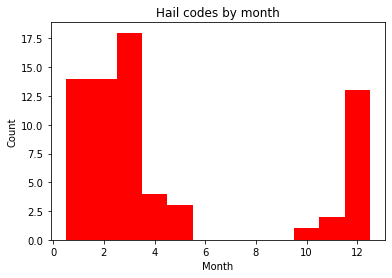

In [25]:
#Histogram of remaining NaN's
histHailCount(hail_events[hail_events[AHC].isna()])
#Lots remaining in the winter months. These are probably sleet.

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    hail_events[AHC][hail_events[AHC].isna() & (
        (hail_events['Month'] == 12) | (hail_events['Month'] <= 2))] = SLEET
    print(REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 25
    print('List of remaining unassigned hail codes:')
    print(hail_events[hail_events[AHC].isna()][['Airport','StartTimeLocal','EndTimeLocal']])

Remaining unassigned Hail codes: 28
List of remaining unassigned hail codes:
      Airport             StartTimeLocal               EndTimeLocal
1712      JFK  2019-03-10 06:19:00-04:00  2019-03-10 06:51:00-04:00
2481      ORD  2016-04-25 22:29:00-05:00  2016-04-25 22:35:00-05:00
5671      BOS  2017-03-31 21:16:00-04:00  2017-03-31 23:30:00-04:00
7659      DEN  2016-05-26 14:48:00-06:00  2016-05-26 14:53:00-06:00
7667      DEN  2016-05-27 13:43:00-06:00  2016-05-27 13:53:00-06:00
8190      DEN  2017-10-08 22:25:00-06:00  2017-10-08 23:12:00-06:00
8412      DEN  2018-04-20 22:43:00-06:00  2018-04-20 23:23:00-06:00
8462      DEN  2018-05-14 01:24:00-06:00  2018-05-14 01:29:00-06:00
9334      MCO  2016-03-26 19:51:00-04:00  2016-03-26 19:59:00-04:00
13068     DFW  2019-03-24 23:14:00-05:00  2019-03-24 23:28:00-05:00
13790     EWR  2016-11-19 23:18:00-05:00  2016-11-19 23:35:00-05:00
14558     EWR  2018-03-02 07:51:00-05:00  2018-03-02 08:18:00-05:00
14606     EWR  2018-03-20 18:51:00-04:0

Most of the remaining events are in March, when weather is highly variable.
It is probably best to just look up these remaining events. We will go here:
    
https://www.wunderground.com/

Temperatures of at least 50F probably correspond to hail, and those below 50
probably correspond to sleet. Other signs to look for: Sudden drops in temperature
are a sign of cold fronts, which hail almost never follows, but if the temperature
quickly recovers it is more likely to be heavy rain, which hail usually accompanies.

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    hail_events.loc[1712, AHC] = SLEET #JFK, 2019-Mar-10, temp = 36F
    hail_events.loc[2481, AHC] = HAIL #ORD, 2016-Apr-25, temp = 69F   
    hail_events.loc[5671, AHC] = SLEET #BOS, 2017-Mar-31, temp = 34F
    hail_events.loc[7659, AHC] = SLEET #DEN, 2018-May-26, temp = 47F after a drop from 61F
    #Below: Brief dip in temperature, potentially a heavy rain core.
    hail_events.loc[7667, AHC] = HAIL #DEN, 2018-May-27, temp = 54F
    hail_events.loc[8190, AHC] = SLEET #DEN, 2017-Oct-08, temp = 34F
    hail_events.loc[8412, AHC] = SLEET #DEN, 2018-Apr-20, temp = 34F
    hail_events.loc[8462, AHC] = HAIL #DEN, 2018-May-14, temp = 50F (nighttime)
    hail_events.loc[9334, AHC] = HAIL #MCO, 2016-Mar-26, temp = 74F
    hail_events.loc[13068, AHC] = HAIL #DFW, 2019-Mar-24, temp = 68F
    hail_events.loc[13790, AHC] = SLEET #EWR, 2016-Nov-19, temp = 46F after a drop from 56F
    hail_events.loc[14558, AHC] = SLEET #EWR, 2018-Mar-02, temp = 39F
    hail_events.loc[14606, AHC] = SLEET #EWR, 2018-Mar-20, temp = 39F
    hail_events.loc[14607, AHC] = SLEET #EWR, 2018-Mar-20, temp = 39F
    hail_events.loc[14609, AHC] = SLEET #EWR, 2018-Mar-20, temp = 38F
    hail_events.loc[15261, AHC] = SLEET #EWR, 2019-Mar-10, temp = 36F
    hail_events.loc[15263, AHC] = SLEET #EWR, 2019-Mar-10, temp = 37F
    hail_events.loc[17681, AHC] = SLEET #ATL, 2016-Mar-03, temp = 47F, which then dropped
    hail_events.loc[18757, AHC] = HAIL #ATL, 2018-Mar-20, temp = 61F
    hail_events.loc[19490, AHC] = HAIL #ATL, 2019-Mar-25, temp = 59F
    #Below: CLT, 2018-Mar-24, no precip recorded. Unreliable data point.
    hail_events.drop(24678, inplace=True)
    weather_events.drop(24678, inplace=True)
    hail_events.loc[24694, AHC] = SLEET #CLT, 2018-Apr-08, temp = 37F
    #Below: CLT, 2018-Nov-11, no precip recorded. Unreliable data point.
    hail_events.drop(25083, inplace=True)
    weather_events.drop(25083, inplace=True)
    hail_events.loc[25378, AHC] = SLEET #CLT, 2019-Mar-08, temp = 44F
    hail_events.loc[25380, AHC] = SLEET #CLT, 2019-Mar-08, temp = 43F
    hail_events.loc[25383, AHC] = SLEET #CLT, 2019-Mar-08, temp = 47F
    hail_events.loc[25385, AHC] = SLEET #CLT, 2019-Mar-08, temp = 48F
    hail_events.loc[25473, AHC] = HAIL #CLT, 2019-Apr-26, temp = 64F  
    
    print('\n', REM_NANS, hailCodeNaNs(hail_events)) #Remaining count: 0

#Update the full DataFrame with these imputed data.
weather_events.loc[(hail_events[hail_events[AHC]==SLEET]).index, 'Type'] = 'Sleet'
weather_events.reset_index(inplace=True) #for the two CLT dropped codes
#These codes were already "Hail", so there is nothing to impute there.


 Remaining unassigned Hail codes: 0


In [28]:
# Get rid of some variables that are no longer needed.
del(hailEndTimeGap, hailEventIndices, hailStartTimeGap, hail_events, events_next,
    hail_next_events, hail_next_events_ZeroTimeGap, events_prior, hail_prior_events,
    hail_prior_events_ZeroTimeGap, hours_EndTimeGap, hours_StartTimeGap, nAn_indeces, nRows,
    n_hail, ICAO_codes, REM_NANS, events_outside_our_years, time_gap, unique_airports_weather,
    weather_EWR, weather_ORD, weather_PHX, boolean_prior, boolean_next, HAIL, SLEET)

Investigate weather types and declare numeric variables for them.
Begin transitioning to the daily_weather DataFrame.

In [29]:
severity_value_counts = weather_events.Type.value_counts()
print(severity_value_counts)
severity_value_counts.to_csv('severity_value_counts.csv')
for weatherType in weather_events.Type.unique():
    print('\nSeverities for weather type ' + weatherType + ':')
    print(weather_events[weather_events.Type==weatherType].Severity.value_counts())
print('\nSeverities for all types:\n', weather_events.Severity.value_counts())

Rain             24127
Fog               3811
Snow              2306
Precipitation      553
Wind               172
Sleet               92
Cold                47
Hail                16
Name: Type, dtype: int64

Severities for weather type Rain:
Light       18506
Moderate     4251
Heavy        1370
Name: Severity, dtype: int64

Severities for weather type Fog:
Moderate    1932
Severe      1879
Name: Severity, dtype: int64

Severities for weather type Snow:
Light       1570
Moderate     561
Heavy        175
Name: Severity, dtype: int64

Severities for weather type Precipitation:
UNK    553
Name: Severity, dtype: int64

Severities for weather type Sleet:
Other    92
Name: Severity, dtype: int64

Severities for weather type Wind:
Severe    172
Name: Severity, dtype: int64

Severities for weather type Cold:
Severe    47
Name: Severity, dtype: int64

Severities for weather type Hail:
Other    16
Name: Severity, dtype: int64

Severities for all types:
 Light       20076
Moderate     6744
Sever

Rain: Light, Moderate, Heavy<br>
Fog: Moderate, Severe<br>
Snow: Light, Moderate, Heavy<br>
Precipitation: UNK (we need to fix this)<br>
Hail: Other<br>
Sleet: Other<br>
Storm: Severe<br>
Cold: Severe<br>

In [30]:
daily_weather = weather_events.copy()

DF_width = len(daily_weather.columns) #get this now before new columns added
daily_weather['HailCode'] = (daily_weather.Type == 'Hail').map(int)
daily_weather['SleetCode'] = (daily_weather.Type == 'Sleet').map(int)
daily_weather['HiWindCode'] = (daily_weather.Type == 'Wind').map(int) #See later
daily_weather['ColdCode'] = (daily_weather.Type == 'Cold').map(int)

In [31]:
LightModerateHeavy = {'Light':1, 'Moderate':2, 'Heavy':3}
daily_weather['RainCode'] =\
    daily_weather[daily_weather.Type=='Rain'].Severity.map(LightModerateHeavy)
daily_weather.RainCode = daily_weather.RainCode.fillna(value=0)
daily_weather['FogCode'] =\
    daily_weather[daily_weather.Type=='Fog'].Severity.map({'Moderate':1, 'Severe':2})
daily_weather.FogCode = daily_weather.FogCode.fillna(value=0)
daily_weather['SnowCode'] =\
    daily_weather[daily_weather.Type=='Snow'].Severity.map(LightModerateHeavy)
daily_weather.SnowCode = daily_weather.SnowCode.fillna(value=0)
FIRST_WEATHER_CODE = (daily_weather.columns)[DF_width] #needed later

In [32]:
#Fix the "Precipitation" and "UNK" entries.
PRECIP = 'Precipitation'; UNK = 'UNK'
print('Count of "' + PRECIP + '" XOR "' + UNK + ':"', len(daily_weather\
    [((daily_weather.Type == PRECIP) &
      (daily_weather.Severity != UNK)) |
      ((daily_weather.Type != PRECIP) &
      (daily_weather.Severity == UNK))].index)) #Perfect match!

Count of "Precipitation" XOR "UNK:" 0


In [33]:
print('\nImputing these events')
for airport in busiest_US_airports2018:
    airport_indeces = daily_weather[daily_weather.Airport == airport].index
    if airport_indeces.size > 0:
        assert np.max(np.diff(airport_indeces)) == 1,\
            'Indexes misaligned for ' + str(airport)
        weather_current_airport = daily_weather.loc[airport_indeces]
        unknown_precip_indeces = weather_current_airport\
            [weather_current_airport.Type == PRECIP].index
        if len(unknown_precip_indeces)==0:
            print(airport, 'has no unknown precipitation')
        else:
            weather_before_indeces = unknown_precip_indeces-1
            weather_after_indeces = unknown_precip_indeces+1
            try:
                weather_current_airport.loc[weather_before_indeces[0]]
            except KeyError:
                raise ValueError('First weather event at', airport, 'is unknown precip')
            try:
                weather_current_airport.loc[weather_after_indeces[-1]]
            except KeyError:
                raise ValueError('Last weather event at', airport, 'is unknown precip')
            # Will need to code a workaround if either of these issues arise.
        
            # Impute based on averages from entries immediately before and after.
            # Round up decimals to nearest integer.
            imputation_values = np.ceil((
                weather_current_airport.loc[weather_before_indeces, FIRST_WEATHER_CODE:].values
                + weather_current_airport.loc[weather_after_indeces, FIRST_WEATHER_CODE:].values)/2).astype(int)
            for i, index in enumerate(unknown_precip_indeces):
                daily_weather.loc[index, FIRST_WEATHER_CODE:] = imputation_values[i]
    else:
        print(airport, 'has no entries')


Imputing these events


Index(['index', 'Airport', 'Type', 'Severity', 'StartTimeLocal',
       'EndTimeLocal', 'HailCode', 'SleetCode', 'HiWindCode', 'ColdCode',
       'RainCode', 'FogCode', 'SnowCode'],
      dtype='object')
Longest weather event: 23.1 hours


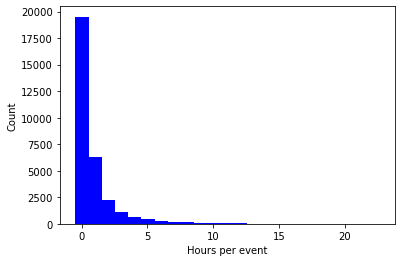

In [34]:
print(daily_weather.columns)
daily_weather = daily_weather.drop(['Type', 'Severity'], axis=1)

# Analyze the lengths of the weather events.
weather_duration = daily_weather.apply(
    lambda row: (row['EndTimeLocal'] - row['StartTimeLocal']).seconds/3600, axis=1)
longestEvent = max(weather_duration)
print('Longest weather event: %.1f hours' % longestEvent) # <24 hours. Good.
plt.hist(weather_duration, bins=int(longestEvent), color='b', align='left')
plt.xlabel('Hours per event')
plt.ylabel('Count')
plt.savefig(r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\figures\HoursPerWeatherEvent.png')
plt.show() #Most events are < 2 hours, and almost all are < 8 hours.

In [35]:
# Organize events by date
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    daily_weather['StartDate'] = daily_weather.apply(lambda row: row['StartTimeLocal'].date(), axis=1)
    daily_weather['EndDate'] = daily_weather.apply(lambda row: row['EndTimeLocal'].date(), axis=1)
weather_starts = daily_weather.copy()
weather_ends = daily_weather.copy()
weather_starts = weather_starts.drop(['StartTimeLocal','EndTimeLocal','EndDate'], axis=1)
weather_ends = weather_ends.drop(['StartTimeLocal','EndTimeLocal','StartDate'], axis=1)

# Form a pivot table based on the highest precip code in each column per day.
weather_starts = pd.pivot_table(data=weather_starts, index=['Airport','StartDate'], aggfunc=np.max)
weather_ends = pd.pivot_table(data=weather_ends, index=['Airport','EndDate'], aggfunc=np.max)

In [36]:
# Append weather_starts and weather_ends (the columns are the same).
# We no longer need the daily_weather DF, so name the result that.
daily_weather = weather_starts.append(weather_ends).sort_index()

# Find the max over each date and rename the index.
daily_weather = pd.pivot_table(data=daily_weather, index=['Airport','StartDate'], aggfunc=np.max)
daily_weather.index.names = ['Airport','Date']
print(daily_weather.head())

weather_codes = pd.Series(daily_weather.columns)

                    ColdCode  FogCode  HailCode  HiWindCode  RainCode  \
Airport Date                                                            
ATL     2016-01-08         0      0.0         0           0       2.0   
        2016-01-09         0      2.0         0           0       1.0   
        2016-01-10         0      0.0         0           0       1.0   
        2016-01-15         0      2.0         0           0       3.0   
        2016-01-16         0      2.0         0           0       0.0   

                    SleetCode  SnowCode  index  
Airport Date                                    
ATL     2016-01-08          0       0.0  17543  
        2016-01-09          0       0.0  17547  
        2016-01-10          0       0.0  17548  
        2016-01-15          0       0.0  17566  
        2016-01-16          0       0.0  17568  


In [37]:
#Get the correlation matrix of data with X's features as columns. Rounding is arbitrary.
def corrMatrixAndMax(df, labels=weather_codes, trims=0):
    corr = df.corr().round(3)
    if trims>0:
        corr = corr.iloc[:-trims, :-trims]
    n = corr.shape[0]
    max_corr_ID = np.argmax(np.abs(corr) - np.eye(n))
    return corr, np.unravel_index(max_corr_ID, [n,n])

In [38]:
#Get the value, and row and column labels of a particular df coordinate. Rounding is arbitrary.
def getCorrNameCoords(df, coordinates):
    row = coordinates[0]; col = coordinates[1]
    return round(df.iloc[row, col], 3), df.index[row], df.index[col]

In [39]:
column_renames = {'ColdCode':'Cold',
                  'FogCode':'Fog',
                  'HailCode':'Hail',
                  'SleetCode':'Sleet',
                  'RainCode':'Rain',
                  'SnowCode':'Snow',
                  'HiWindCode':'Wind'}
daily_weather.rename(columns=column_renames, inplace=True)

In [40]:
corr, coords_max_corr = corrMatrixAndMax(daily_weather, trims=1)
print('\nWeather code correlation matrix:\n' + str(corr))
print('Greatest correlation:', getCorrNameCoords(corr, coords_max_corr))


Weather code correlation matrix:
        Cold    Fog   Hail   Wind   Rain  Sleet   Snow
Cold   1.000 -0.012 -0.003  0.017 -0.064  0.015  0.014
Fog   -0.012  1.000  0.003 -0.005 -0.265 -0.010  0.095
Hail  -0.003  0.003  1.000  0.038  0.045 -0.003 -0.011
Wind   0.017 -0.005  0.038  1.000  0.038 -0.009  0.017
Rain  -0.064 -0.265  0.045  0.038  1.000  0.006 -0.206
Sleet  0.015 -0.010 -0.003 -0.009  0.006  1.000  0.199
Snow   0.014  0.095 -0.011  0.017 -0.206  0.199  1.000
Greatest correlation: (-0.265, 'Fog', 'Rain')


The negative correlation between fog and rain is not too surprising. Fog is a
calm-weather event, and rain is often not. Note the positive correlation between
sleet and snow, which we expect, but sleet and hail are almost completely
uncorrelated despite once being the same code. Rain and snow are negatively
correlated, which actually makes sense, since snow requires below-freezing temperatures
while rain rarely sees such temperatures. The correlation between hail and high
wind is surprisingly low, but high winds and hail do not require each other.
That most of the correlations are low suggests that we can treat most of the variables
separately when it is time to train the data.

In [41]:
# Save the DataFrame and proceed to the flight_data.
if save_data:
    daily_weather.to_csv('daily_weather.csv')
    corr.to_csv('weather_code_corr.csv')
print('\nTotal runtime:', stopwatch.getElapsedTime())


Total runtime: --- 45.19 seconds ---
